## Classifying NBA Player Positions by K-Means Clustering

The purpose of this analysis is to see if we can use K-Meeans clustering to accurately predict the position of each player based on their height and weight.

First, we need to scrape the data (<a href="https://github.com/aaronpetryio/nba-position-guesser/blob/master/nba-player-scraper.py">data scraper here</a>) from <a href="basketball-reference.com/">Basketball Reference</a>. Then, we will clean and modify the data so that it can be used for K-Means clustering. Next, we will apply the clustering algorithm, assign position integers based on the K-Means centers, and then check the accuracy of the predictions. Finally, we will draw a conclusion based on our data, the predictions, and the accuracy of those predictions.

### Step 1: Analyze and Clean the Data

The data will need to be analyzed, cleaned, and prepared for the K-Means Clustering.

In [4]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [5]:
#Read in the data to a dataframe
nba_player_data = pd.read_csv('nba_player_data_2020.csv')

In [5]:
#Print the .head() of the dataframe for a sanity check
print(nba_player_data.head())

#Print the .info() of the dataframe for a deeper investigation
print(nba_player_data.info())

  Team No.            Player Pos   Ht   Wt        Birth Date Country Exp  \
0  MIL  11       Brook Lopez   C  7-0  282     April 1, 1988      us  12   
1  MIL   9   Wesley Matthews  SG  6-4  220  October 14, 1986      us  11   
2  MIL  24   Pat Connaughton  SG  6-5  209   January 6, 1993      us   5   
3  MIL   0  Donte DiVincenzo  SG  6-4  203  January 31, 1997      us   2   
4  MIL  42       Robin Lopez   C  7-0  281     April 1, 1988      us  12   

      College  
0    Stanford  
1   Marquette  
2  Notre Dame  
3   Villanova  
4    Stanford  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Team        510 non-null    object
 1   No.         489 non-null    object
 2   Player      510 non-null    object
 3   Pos         510 non-null    object
 4   Ht          510 non-null    object
 5   Wt          510 non-null    int64 
 6   Birth Date  510 n

As shown, the 'Ht' column is not an integer and will be difficult for computation. We will convert this to inches in a new column named 'Ht_Inches'.

In [7]:
#Create a 'Ft' column which takes the first digit in the 'Ht' column and converts it to an integer
nba_player_data['Ft'] = nba_player_data['Ht'].str[:1].astype(int)

#Create a 'In' column which takes the second digits in the 'Ht' column and converts it to an integer
nba_player_data['In'] = nba_player_data['Ht'].str.split('-').str[1].astype(int)

#Create a 'Ht_Inches' column and convert the 'Ht' column to inches
nba_player_data['Ht_Inches'] = (nba_player_data['Ft']*12)+nba_player_data['In']

In [25]:
#Print the .head() of the DataFrame to check if the calculation was successful
print(nba_player_data.head())

  Team No.            Player Pos   Ht   Wt        Birth Date Country Exp  \
0  MIL  11       Brook Lopez   C  7-0  282     April 1, 1988      us  12   
1  MIL   9   Wesley Matthews  SG  6-4  220  October 14, 1986      us  11   
2  MIL  24   Pat Connaughton  SG  6-5  209   January 6, 1993      us   5   
3  MIL   0  Donte DiVincenzo  SG  6-4  203  January 31, 1997      us   2   
4  MIL  42       Robin Lopez   C  7-0  281     April 1, 1988      us  12   

      College  Ft  In  Ht_Inches  
0    Stanford   7   0         84  
1   Marquette   6   4         76  
2  Notre Dame   6   5         77  
3   Villanova   6   4         76  
4    Stanford   7   0         84  


Next, let's look at the unique positions in the dataset. 

In [8]:
#Print out the unique values in the 'Pos' column
print(nba_player_data['Pos'].unique())

['C' 'SG' 'PF' 'SF' 'PG' 'G' 'F' 'F-G' 'G-F' 'F-C']


There are are 10 unique positions in the dataset. Since we only want to focus our analysis on the traditional five positions (C, SG, PF, SF, PG), let's see how many players fall into the non-traditional positions and if it is significant enough to keep for our analysis.

In [9]:
#Print out the value counts for each position
print(nba_player_data['Pos'].value_counts())

SG     130
PF     100
C       92
SF      85
PG      84
F        8
G        7
G-F      2
F-G      1
F-C      1
Name: Pos, dtype: int64


Since there are only 19 players that fall within those categories, we will remove them from our dataset.

In [18]:
#Remove F, G, G-F, F-G, and F-C from our dataframe
nba_player_data = (nba_player_data[(nba_player_data['Pos'] != 'F') & (nba_player_data['Pos'] != 'G')
                                  & (nba_player_data['Pos'] != 'G-F')
                                  & (nba_player_data['Pos'] != 'F-G')
                                  & (nba_player_data['Pos'] != 'F-C')])

In [42]:
#Validate that F, G, G-F, F-G, F-C were removed from our DataFrame
print(nba_player_data['Pos'].value_counts())

SG    130
PF    100
C      92
SF     85
PG     84
Name: Pos, dtype: int64


Next, we will create a scatter plot to visualize how height and weight correlate to position.

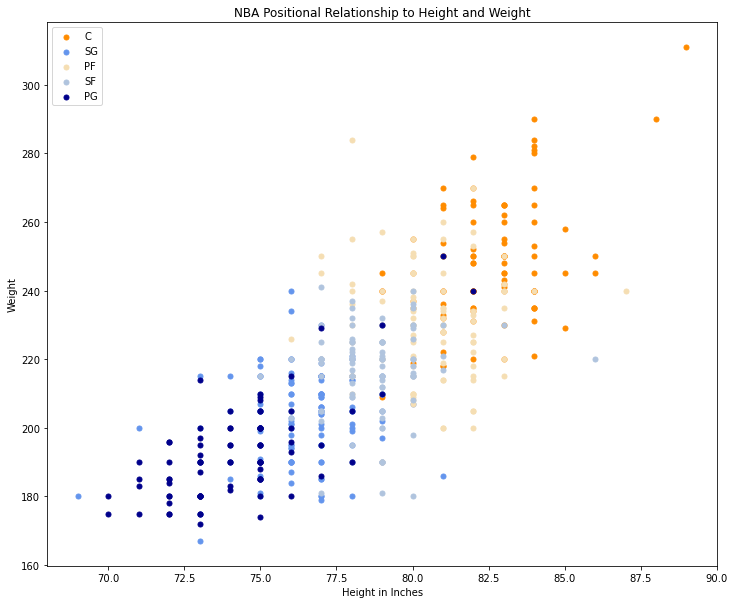

In [26]:
#Create individual dataframes for each of the traditional positions
C_df = nba_player_data.loc[nba_player_data['Pos'] == "C"]
SG_df = nba_player_data.loc[nba_player_data['Pos'] == "SG"]
PF_df = nba_player_data.loc[nba_player_data['Pos'] == "PF"]
SF_df = nba_player_data.loc[nba_player_data['Pos'] == "SF"]
PG_df = nba_player_data.loc[nba_player_data['Pos'] == "PG"]

#Create the figure size, labels, and title for the scatter plot
plt.figure(figsize=(12,10))
plt.xlabel("Height in Inches")
plt.ylabel("Weight")
plt.title("NBA Positional Relationship to Height and Weight")

#Plot each position onto the scatter plot
plt.scatter(C_df['Ht_Inches'], C_df['Wt'], label='C', s=25, c='darkorange')
plt.scatter(SG_df['Ht_Inches'], SG_df['Wt'], label='SG', s=25, c='cornflowerblue')
plt.scatter(PF_df['Ht_Inches'], PF_df['Wt'], label='PF', s=25, c='wheat')
plt.scatter(SF_df['Ht_Inches'], SF_df['Wt'], label='SF', s=25, c='lightsteelblue')
plt.scatter(PG_df['Ht_Inches'], PG_df['Wt'], label='PG', s=25, c='darkblue')

#Create a plot legend
plt.legend(loc='upper left')

#Show the scatter plot
plt.show()

### Step 2: Apply the K-Means Clustering Algorithm

Can a K-Means clustering algorithm accurately predict a player's position based on their height and weight? We can now attempt to solve this question.

In [1]:
#Import SNS and KMeans
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
#Initialize KMeans with 5 clusters
kmeans = KMeans(n_clusters=5)

In [8]:
#Fit the model with the 'Ht_Inches' and 'Wt' columns
kmeans.fit(nba_player_data[['Ht_Inches', 'Wt']])

KMeans(n_clusters=5)

In [10]:
#Add the KMeans labels as a column to the nba_player_data dataframe
nba_player_data['KMeans_Labels'] = pd.Series(kmeans.labels_, index=nba_player_data.index)

Let's check out our nba_player_data dataframe to see if the K-Means labels were added as expected.

In [11]:
#Print the .head() of the dataframe to see if the 'KMeans_Labels' column was added
print(nba_player_data.head())

  Team No.            Player Pos   Ht   Wt        Birth Date Country Exp  \
0  MIL  11       Brook Lopez   C  7-0  282     April 1, 1988      us  12   
1  MIL   9   Wesley Matthews  SG  6-4  220  October 14, 1986      us  11   
2  MIL  24   Pat Connaughton  SG  6-5  209   January 6, 1993      us   5   
3  MIL   0  Donte DiVincenzo  SG  6-4  203  January 31, 1997      us   2   
4  MIL  42       Robin Lopez   C  7-0  281     April 1, 1988      us  12   

      College  Ft  In  Ht_Inches  KMeans_Labels  
0    Stanford   7   0         84              4  
1   Marquette   6   4         76              3  
2  Notre Dame   6   5         77              0  
3   Villanova   6   4         76              0  
4    Stanford   7   0         84              4  


Next, using Seaborn, let's plot the NBA positional relationship to height and weight, but color the scatter plots using the K-Means labels.

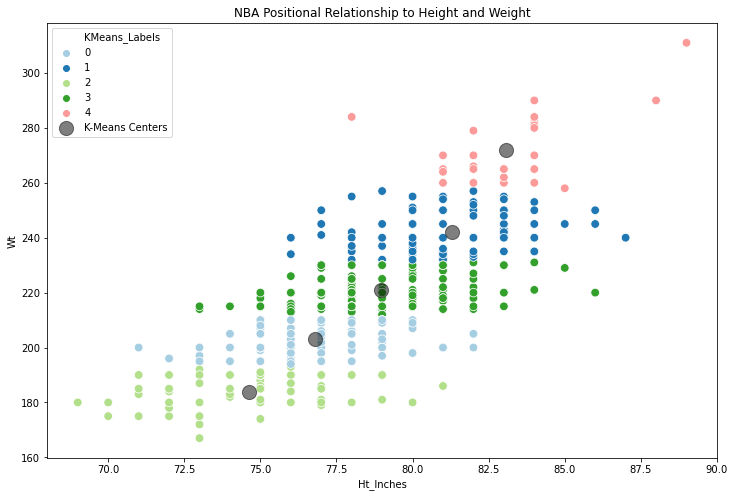

In [25]:
#Create the figure size, labels, and title for the scatter plot
plt.figure(figsize=(12,8))
plt.xlabel('Height in Inches')
plt.ylabel('Weight')
plt.title('NBA Positional Relationship to Height and Weight')

#Plot the height and weight and color based on K-Means labels
sns.scatterplot(x='Ht_Inches',y='Wt',data=nba_player_data,hue='KMeans_Labels',palette='Paired',s=75)

#Plot the KMeans centers
centers = kmeans.cluster_centers_
plot_centers = plt.scatter(centers[:,0],centers[:,1],c='black',s=200,alpha=0.5,label='K-Means Centers')

#Create a legend
plt.legend(loc='upper left')

#Show the scatter plot
plt.show()

As we can see above, the cutoffs between the clusters correlates to weight and not necessarily a relationship between height and weight. This tells us that the prediction may not be as accurate as we would have hoped, but let's continue. 

Next, we will analyze the K-Means centers and compare those to the average height and weight for each position group. 

In [16]:
#Assign the K-Means centers and print the results
kmeans_centers = kmeans.cluster_centers_
print(kmeans_centers)

[[ 76.80952381 203.06349206]
 [ 81.30434783 242.22608696]
 [ 74.62790698 183.96511628]
 [ 78.94871795 220.78205128]
 [ 83.07407407 271.88888889]]


These centers correspond to what is the predicted average height (the X) and the average weight (the Y). Let's see what the mean weight and height is in our dataset for each position.

In [19]:
#Find the height and weight means by position and print the results
Ht_Wt_Means = nba_player_data.groupby('Pos')[['Ht_Inches', 'Wt']].mean()
print(Ht_Wt_Means)

     Ht_Inches          Wt
Pos                       
C    82.608696  248.076087
PF   80.420000  230.350000
PG   74.226190  192.702381
SF   78.717647  216.623529
SG   76.476923  203.553846


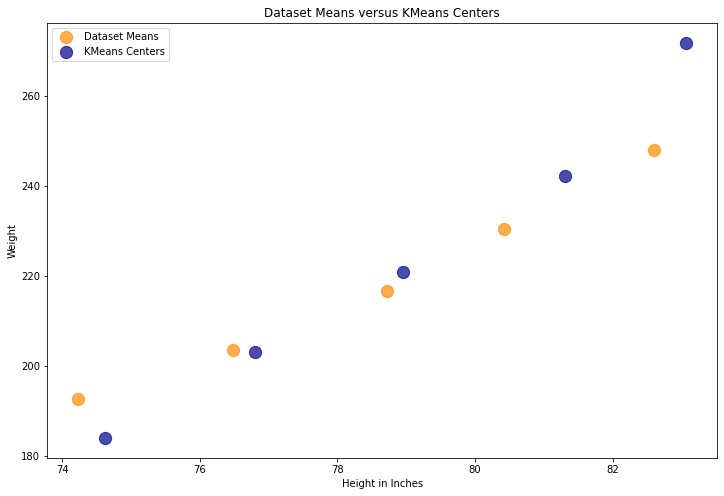

In [26]:
#Create the figure size, labels, and title for the scatter plot
plt.figure(figsize=(12,8))
plt.ylabel('Weight')
plt.xlabel('Height in Inches')
plt.title('Dataset Means versus KMeans Centers')

#Plot the means and the centers onto the scatter plot
plt.scatter(x=Ht_Wt_Means['Ht_Inches'],y=Ht_Wt_Means['Wt'],c='darkorange',label='Dataset Means',s=150,alpha=0.7)
plt.scatter(x=[i[0] for i in centers],y=[i[1] for i in centers],c='darkblue',label='KMeans Centers',s=150,alpha=0.7)

#Create a legend
plt.legend(loc='upper left')

#Show the scatter plot
plt.show()

As you can see, the comparison is close, but as moves towards taller players, the dataset means and the K-Means centers differ more. 

Next, let's create a column that assigns a position to an integer. This will allow us to compare the K-Means label assigned to each player to their actual position. With this comparison, we can see how accurate the K-Means classification algorithm is. 

We have determined that the following integers should be used for each position based on where the majority of the players land in the scatter plot versus the K-Means centers numbers.

<b>Positions:</b><br>
C = 4<br>
SF = 3<br>
PG = 2<br>
PF = 1<br>
SG = 0<br>

In [35]:
#Create a function that will assign an integer based on position to our dataframe
def position_to_integer(position):
    if position == 'C':
        return 4
    if position == 'SF':
        return 3
    if position == 'PG':
        return 2
    if position == 'PF':
        return 1
    if position == 'SG':
        return 0

In [38]:
#Apply the function to our dataframe to add a new column with the position integer
nba_player_data['Pos_Integer'] = nba_player_data.apply(lambda x: position_to_integer(x['Pos']), axis = 1)

In [43]:
#Print the .head() of the dataframe to see if the 'Pos_Integer' column was added
print(nba_player_data.head())

  Team No.            Player Pos   Ht   Wt        Birth Date Country Exp  \
0  MIL  11       Brook Lopez   C  7-0  282     April 1, 1988      us  12   
1  MIL   9   Wesley Matthews  SG  6-4  220  October 14, 1986      us  11   
2  MIL  24   Pat Connaughton  SG  6-5  209   January 6, 1993      us   5   
3  MIL   0  Donte DiVincenzo  SG  6-4  203  January 31, 1997      us   2   
4  MIL  42       Robin Lopez   C  7-0  281     April 1, 1988      us  12   

      College  Ft  In  Ht_Inches  KMeans_Labels  Pos_Integer  
0    Stanford   7   0         84              4            4  
1   Marquette   6   4         76              3            0  
2  Notre Dame   6   5         77              0            0  
3   Villanova   6   4         76              0            0  
4    Stanford   7   0         84              4            4  


Now, we can compare the two using Sklearn's classification report. 

In [44]:
#Import SKlearn's Classification Report
from sklearn.metrics import classification_report

In [50]:
#Generate a classificaiton report based on the position integers and the K-Means labels
position_classification_report = classification_report(nba_player_data['Pos_Integer'],nba_player_data['KMeans_Labels'])

#Print the classification report
print(position_classification_report)

              precision    recall  f1-score   support

           0       0.50      0.48      0.49       130
           1       0.39      0.43      0.41       100
           2       0.58      0.58      0.58        84
           3       0.36      0.62      0.46        85
           4       0.89      0.26      0.40        92

    accuracy                           0.47       491
   macro avg       0.55      0.47      0.47       491
weighted avg       0.54      0.47      0.47       491



As we predicted, not very accurate. Let's see which positions are our most accurate in graph form.

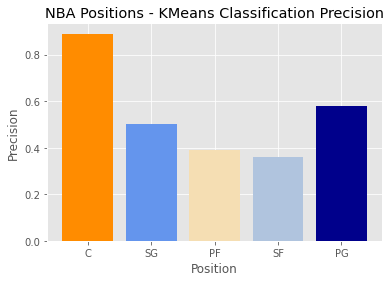

In [54]:
#Plot each position's precision and color based on our original scatter plot
plt.bar("C", .89, color='darkorange')
plt.bar("SG", .50, color='cornflowerblue')
plt.bar("PF", .39, color='wheat')
plt.bar("SF", .36, color='lightsteelblue')
plt.bar("PG", .58, color='darkblue')

#Label and title the bar plot
plt.xlabel("Position")
plt.ylabel("Precision")
plt.title("NBA Positions - KMeans Classification Precision")

#Show the bar plot
plt.show()

### Step 3: Analyze the Results 

Our most accurate prediction was the center position. This makes sense as there isn't a lot of overlap between positions as you start to move towards the taller players. Our next most accurate is the point guard position which also makes sense for reasons similar to center. 

As you start to get to shooting guard, power forward, and shooting forward, there is less accuracy as these players tend to be similar weight and height. There are other factors that will determine the player's position and if we expand our dataset to include things such as shooting accuracy and floor position, we could probably raise the accuracy of our predictions.

Although we didn't achieve a high accuracy, I am still surprised we achieved a 55% accuracy across positions. I am excited to leverage K-Means clustering in future data analysis. 